# Chainer를 사용하여 반복 학습(training loop) 코드 작성하기

## NOTE
+ 이 내용은 chainer tutorial english translation 버전을 기반으로 작성되었으며 최대한 이해를 돕는 쪽으로 번역을 진행하였습니다. Chainer의 내장 클래스들 중에 몇 가지 단어가 겹치는 경우 (예를 들어, Iterator의 경우는 단순히 반복자라고 번역할 수 있으나, Chainer의 하나의 내장 클래스로써 존재하는 Iterator를 가리키는 경우) 번역하지 않고 있는 그대로 사용하려 노력했습니다.
+ Training Loop의 경우 하나의 고유명사로 이해하셔도 좋고 혹은 단순히 학습 루틴, 학습 흐름, 학습 정도로 의역할 수 있지만 neural network의 학습 과정 자체가 loss를 계산하고 이를 이용하여 역전파 계산을 수행 후 파라미터를 조정하는 과정을 반복하는 형태이므로 이러한 흐름 이해를 돕기 위해 반복 학습이라고 의역하였습니다. iteration 또한 같은 맥락으로 반복 주기라고 의역하였습니다. 
+ dataset의 경우 데이터 집합으로 번역할 수 있지만 조금 더 직관적으로 받아들이는데엔 데이터셋이라는 표현이 좋을 것 같아 그렇게 사용하였습니다.
+ Occasionally라는 표현이 자주 등장하는데, 직역으로 가끔이라는 표현보다는 주기적이라는 표현이 문맥상 더 어울리기 때문에 주기적으로 라고 의역하였습니다.
+ 이외에 간간히 편리하다 등의 직역을 우리나라 말에 맞게 의역하여 최대한 이해를 도우려 했습니다. 
+ 본문의 이해를 돕기 위한 부가적인 코멘트를 넣었을 경우 코멘트의 위 아래에 가로줄을 넣어 구분지었습니다.

<hr/>
이 notebook 세션에서는 손글씨로 쓰여진 숫자들을 인식하는데 쓰이는 대표적인 데이터셋인 MNIST를 활용하여 어떻게 딥러닝을 할 것인지 다루어 볼 것입니다.
이 데이터셋은 5만개의 학습 예제 데이터들과 1만개의 테스트 데이터들로 구성되어 있습니다. 각각의 데이터들은 28x28의 grayscale 이미지와 해당 이미지가 의미하는 숫자로 구성되어있죠. 숫자는 0부터 9까지가 쓰였기 때문에 총 10개의 분류 레이블이 있습니다.
 
Chainer에서는 `Trainer`라고 부르는 클래스를 활용하여 학습 과정을 단순화 할 수 있습니다만, Chainer를 처음 다뤄보는 유저들에게는 `Trainer`를 곧바로 사용하기보다는 먼저 **Chainer의 학습 과정 자체를 이해하는 것이 중요합니다**. 심화된 내용을 다루는 유저들 조차도 가끔씩 그들만의 반복 학습 코드를 작성해야할 일이 생기게 되기 때문이죠. 따라서 어떻게 작성해야 하는지 여기에서 미리 다루어보고자 합니다.

학습 과정은 아래와 같은 단계로 이루어져 있습니다 :

1. train/validation/test 데이터가 있는 데이터셋을 준비합니다.
2. 부가적으로 데이터셋에 적용할 반복자(iterator)들을 설정합니다.
3. 각 반복 주기(iteration)마다 아래와 같은 연산을 수행하는 반복 학습 코드를 작성합니다 :
    1. 학습 데이터셋에서 데이터들의 batch를 받아옵니다.
    2. model에 받아온 batch를 넣어줍니다.
    3. model에서 forward 계산을 수행하여 오차(loss)를 계산합니다.
    4. back pass(=back propagation)을 수행하여 model의 그레디언트(gradient)를 계산합니다.
    5. optimizer를 사용하여 model의 파라미터(parameter)를 수정합니다.
    6. (부가): 때때로 validation/test 셋을 사용하여 현재 성능을 체크합니다.
    

## 1. 데이터셋(dataset) 준비하기

Chainer에는 머신러닝이나 딥러닝 커뮤니티에서 사용하는 유명한 데이터셋을 손쉽게 다운로드해준 뒤 Chainer의 형태에 맞게 변환해주는 편리한 내장 함수를 포함하고 있습니다. 이 예제에서는 MNIST 데이터셋을 받을 수 있는 함수를 사용해보도록 하겠습니다.

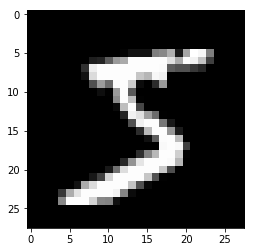

label: 5


In [1]:
from chainer.datasets import mnist

# MNIST 데이터가 없다면 다운로드 받아줌
train, test = mnist.get_mnist(withlabel=True, ndim=1)

# matplotlib를 사용하여 이 notebook 안에 그릴 수 있도록 함
%matplotlib inline
import matplotlib.pyplot as plt

# MNIST 데이터셋의 예제를 보여줌.
# 'x' : 입력 이미지의 배열 // 't' : 해당 이미지의 클래스
# 정수로 라벨링함.
x, t = train[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

## 2. 데이터셋 반복자(iterator) 만들기

사실 이 단계는 부가적인 단계이지만 반복자(iterator)들은 데이터셋을 학습 과정에 사용하는데 있어 굉장히 편리하게 만들어주고 이러한 반복자들의 주 역할은 일정 갯수의 데이터들을 반환하는 것입니다(이것을 'mini-batch'라고도 부름). 매 번 일정 갯수의 데이터들을 반환하는 것을 두고 그 갯수를 "batch size" 혹은 "mini-batch size"라고 부르기도 합니다. Chainer는 위와 같은 목적을 수행하기 위해 이미 `Iterator`라는 클래스와 일부 서브클래스들을 가지고 있으며 또한 유저들로 하여금 본인들의 고유한 반복자 또한 작성하기 쉽게 되어있습니다.
>이 글에서는, Chainer의 Iterator를 말할 때에는 반복자라 번역하지 않고 Iterator로 그대로 표기하겠습니다

이 예제에서는 `Iterator`의 서브클래스인 `SerialIterator`를 사용해볼 것입니다. `SerialIterator`는 데이터셋에 담긴 순서대로 데이터들을 끄집어 내어 반환할 수도 있고 임의의 순서대로 섞어서 데이터들을 끄집어낼 수도 있습니다. 

Iterator에서는 next() 메서드를 사용하여 다음 mini-batch를 반환 받을 수 있습니다. 또한 Iterator는 학습을 관리하는 속성도 가지고 있는데, 'epoch' 의 경우 전체 데이터셋이 몇 회 쓰였는지 알려주는 속성이고 'is_new_epoch' 는 현재 반복 횟수가 새로운 epoch의 첫 반복 횟수인지 알려주는 메서드입니다.
<hr/>
+ 'epoch'는 보통 세대라고도 표현을 하고 매 반복 학습을 거쳐 전체 데이터셋을 한 번씩 사용했을 경우 1 세대를 거쳤다고 표현을 하며 이것을 1epoch 라고도 씁니다. 즉, 데이터셋의 크기가 1만개이고, 2세대를 거쳤다 혹은 2 epoch라고 표현을 할 경우 학습을 위해 총 2만개의 데이터를 사용한 셈이죠.

<hr/>

In [2]:
from chainer import iterators

# Mini-batch size를 설정함
batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize,
                                     repeat=False, shuffle=False)

### SerialIterator에 대해 자세히 알아보기

- `SerialIterator` 는 `Iterator`의 내장 서브클래스이며 데이터셋을 순서대로 반환하거나 섞어서 반환하는데 사용합니다.
- `Iterator` 초기화자는 데이터셋 객체(object)와 batch size 이렇게 두 개의 인수를 가집니다
- 만약 데이터가 학습과정에 있어 반복적으로 사용되어야 한다면 'repeat' 인수를 'True'로 설정해줍니다. 하지만 한 번만 사용하고 이후엔 사용하지 않는다면 'repeat'를 'False'로 설정해주세요.
- 매 epoch(세대) 마다 학습 데이터셋을 섞으려면 'shuffle' 인수를 'True'로 설정해줍니다.
위 예제에서는 'train_iter'는 학습 데이터셋의 Iterator이고 'test_iter'는 테스트 데이터셋의 Iterator이며 각각의 batchsize를 128로 설정했습니다('batchsize = 128'). 따라서 위의 반복자들은 128개의 이미지들을 한 묶음으로써 반환할 것입니다.

## 3. model 정의하기
이제 MNIST 이미지들을 분류하기 위한 neural network를 정의해봅시다. 여기에서는 단순히 3개의 layer(층)으로 이루어져 있는 fully-connected network를 작성할 것입니다. 각각의 hidden layer는 100개의 뉴런 유닛을 가지게 하고 output layer에서는 숫자의 갯수(0-9)인 10개의 뉴런 유닛을 가지게 설정해줄 것입니다.
먼저 `Link`와 `Function`, `Chain`, 그리고 `Variable`이라는 Chainer를 동작시키기 위한 가장 기초적인 요소에 대해 간단하게 설명하고 넘어가겠습니다.

<!-- ### `Link` and `Function` -->
### `Link` 와 `Function`
<!--In Chainer, each layer of a neural network is decomposed into one of two broad types of functions (actually, they are function objects): 'Link' and 'Function'.-->
Chainer에서는 neural network의 각 layer가 크게 두 가지 타입의 함수들('Link', 'Function')으로 나뉘어집니다.
(사실, 얘네들은 함수 객체이죠.)
<hr/>
+ 여기서, 함수는 말 그대로 프로그래밍에서 말하는 함수를 일컫는 것이고 `Function`의 경우 Chainer의 서브클래스를 말하고있습니다.
<hr/>
<!--- ** `Function` is a function without learnable paremeters**-->
- ** `Function` 은 학습 관련 파라미터를 제외한 함수입니다. **
<!--- ** `Link` is a function that conatins (learnable) parameters** We can think of `Link` as wrapping a `Function` to give it parameters. That is, `Link` will contain the parameters and when it is called, it will also call a corresponding `Function`.-->
- ** `Link` 는 학습 관련 파라미터를 포함한 함수입니다. ** 간단하게 `Link`는 `Function`에 파라미터를 전달하기 위한 래핑(wrapping) 함수라고 생각할 수 있습니다. 따라서 `Link`는 호출할 때 파라미터와 함께 호출되며 또 원본 `Function`을 호출할 것이라는 이야기지요.
<!--We then describe a model by implementing code the performs the "forward pass" computations. This code will call various links and chains (recall that `Link` and `Chain` are callable objects). Chainer will take care of the "backward pass" automatically and so we do not need to worry about that unless we want to write some custom funcions.-->
따라서 이제 이를 이용해 "forward pass" 계산을 할 수 있는 모델에 대한 코드를 작성할 수 있고 작성된 코드는 다양한 link와 chain들을 호출할 것입니다(`Link`와 `Chain`은 호출 가능한 객체라고 미리 말하고 가야겠습니다). Chainer는 이렇게 작성된 model에 대해서 알아서 "backward pass"(back propagation)을 신경써주기 때문에 커스텀 함수를 작성하려는 것이 아니라면 이러한 부분은 걱정할 필요가 없습니다.

<!--- For examples of links, see the 'chainer.links' module.-->
- link들의 예제와 관련해서는 'chainer.links' 모듈을 참고하세요.
<!--- For examples of functions, see the 'chainer.functions' module.-->
- 함수들의 예제와 관련해서는 'chainer.functions' 모듈을 참고하세요.
<!--- For example, see the `Linear` link, which wraps the `linear` function to give it weight and bias parameters.-->
- `linear` function를 래핑하여 가중치와 bias 파라미터를 전달하는 link에 관해서는 `Linear` 를 참고하세요.

<!--Before we can start using them, we first need to import the modules as shown below.-->
위의 설명드린 것들을 사용하기 이전에 먼저 아래의 모듈들을 import 해야 합니다.

    ```
    import chainer.links as L
    import chainer.functions as F
    ```
<!--The Chainer convention is to use `L` for links and `F` for functions, like 'L.Convolution2D(...)' or 'F.relu(...)'.-->
Chainer에서의 관습으로써 `L`은 link들을, `F`는 function들을 가리킵니다. 'L.Convolution2D(...)' 혹은 'F.relu(...)' 처럼요.
<hr/>
+ 마치 numpy를 관습적으로 np로 축약해 쓰는 것 처럼 말이죠.
<hr/>

### `Chain`

<!--- `Chain` is a class that can hold multiple links and/or functions. It is a subclass of `Link` and so it is also a `Link`. -->
- `Chain` 은 여러 개의 link들이나 function들, 즉 함수들을 담고 있는 클래스입니다. `Chain`은 `Link`의 서브클래스 이므로 따라서 `Chain` 또한 `Link`라 이야기할 수 있겠죠.
<!--- This means that a chain can contain parameters, which are the parameters of any links that it deeply contains.-->
- 이 말은 즉슨, link와 같이 파라미터를 넣을 수 있다는 말이므로 어떤 복잡한 link들의 파라미터던지 넣을 수 있다는 말이지요.
<!--- In this way, `Chain` allows us to construct models with a potentially deep hierarchy of functions and links.-->
- 따라서 `Chain` 을 통해 잠재적으로 깊은 계층 구조를 가지는 function이나 link를 가지는 model을 작성할 수 있습니다.
<!--- It is often convinient to use a single chain that contains all of the layers (other chains, links, and functions) of the model. This is because we will need to optimize the model's parameters during training and if all of the parameters are contained by a single chain, it turns out to be straightfoward to pass these parameters into an optimizer (which we describe in more detail below).-->
- 하나의 chain에 모든 layer을 집어 넣고 사용하는 것(다른 chain들이나, link들, 그리고 function들도..)이 대체적으로 편합니다. 왜냐하면 학습 과정에서 model의 파라미터를 수정 하는 것이 필요하고 이러한 모든 파라미터들이 하나의 chain 안에 속하게 되기 때문에 따라서 단순히 이러한 파라미터들을 담은 하나의 chain을 optimizer에 던져주기만 하면 됩니다(이 부분은 아래에 더 자세히 설명할 예정임). 즉 복잡한 구조를 지닌 model이라도 하나의 chain으로 묶어서 나타낼 수 있다면 훨씬 더 간단하게 코드로 나타낼 수 있다는 이야기이지요.

### `Variable`
<!--In Chainer, both the activations (that is, the inputs and outputs of function and links) and the model parmaeters are instances of the `Variable` class. A `Variable` holds two arrays: a `data` array that contains the values that are read/written during the forward pass (or the parameter values), and a `grad` array that contains the corresponding gradients that will are computed during the backward pass.-->
Chainer에서 function과 link의 입,출력 변수와 model 파라미터들은 `Variable` 클래스의 인스턴스로 구성되어 있습니다. `Variable`는 2개의 배열을 가지고 있는데 forward pass 중에 읽고 쓰는 데이터들(혹은 파라미터 값들)의 배열인 `data` 와 그에 대한 backward를 계산한 배열인 `grad` 이 그것이죠.

<!--A `Variable` can potentially contain two types of arrays as well, depending whether the array resides in CPU or GPU memory. By default, the CPU is used and these will be Numpy arrays. However, it is possible to move or create these arrays on the GPU as well, in which case they will be CuPy arrays. Fortunately, CuPy uses an API that is nearly identical to Numpy. This is convinient because in addition to making it easier for users to learn (there is almost nothing to learn if you are already familiar with Numpy), it often allows us to reuse the same code for both Numpy and CuPy arrays.-->
`Variable`은 CPU memory나 GPU memory 에 저장된 두 가지 형태의 배열을 포함할 수 있습니다. 기본적으로 CPU memory가 사용될 것이며 이는 Numpy array로써 저장될 것입니다. 그러나 이러한 배열을 CuPy 배열 형태로 변환하여 GPU쪽으로 옮기거나 만드는 것 또한 할 수 있습니다. 다행히도 CuPy는 Numpy와 유사한 API를 지니고 있죠. 대부분의 사람들은 Numpy에 익숙해져 있기 때문에 이러한 부분은 편리하다고 할 수 있겠습니다. 따라서 기존의 Numpy 기준으로 쓰여진 코드를 그대로 CuPy로 재사용 할 수 있겠습니다.

<!--### Create our model as a subclass of 'Chain' -->
### 'Chain'의 서브클래스 형태로 우리만의 model 만들기
<!--We can create our model be writing a new subclass of `Chain`. The two main steps are:-->
이제 `Chain`의 서브 클래스 형태로 우리만의 model을 작성할 수 있겠습니다.

<!--1. Any links (possiblye also including other chains) that we wish to call during the forward computation of our chain must first be supplied to the chain's `__init__` method. After the `__init__` method has been called, these links will then be accessable as attributes of our chain object. This means that we also need to provide the attribute name that we want to use for each link that is supplied. We do this by providing the attribute name and corresponding link object as keyword arguments to `__init__`, as we will do in the `MLP` chain below.-->
1. 어떠한 link이든간에(다른 chain들이 포함되어 있는 경우 또한) 해당 link를 사용하여 작성한 chain에 대한 forward 계산을 가능하게 하려면 먼저 chain의 `__init__` 메서드에 인수로써 제공되어야 합니다. 이 메서드가 호출 된 이후 link들은 작성한 chain object의 하나의 속성으로써 접근가능하게 됩니다. 따라서 제공될 때 각각의 link에 속성명을 부여해야 한다는 뜻이지요. 이 작업을 하기위해 `__init__` 메서드에 인수들로써 각각 link의 이름과 link 객체를 전달해줄 것입이다. 아래의 `MLP` chain을 참고하셔서 이해하시면 되겠습니다.
<!--2. We need to define a `__call__` method that allows our chain to be called like a function. This method takes one or more `Variable` objects as input (that is, the input activations) and returns one or more `Variable` objects. This method executes the forward pass of the model by calling any of the links that we supplied to `__init__` earlier as well as any functions.-->
2. `__call__` 메서드를 통해 작성한 chain이 마치 함수처럼 호출될 수 있도록 미리 정의해 놓아야합니다. 이 메서드는 최소 하나 이상의 `Variable` 객체를 입력으로 받고(이것을 input activation이라 부름) 하나 이상의 `Variable` 객체를 반환합니다. 이 메서드는 앞에서 `__init__` 메서드에서 인수로 제공한 link를 이용하여 model의 forward pass를 수행할 때 실행됩니다. function 또한 마찬가지죠.

<!--Note that only the links need to be supplied to `__init__`. This is because they contain parameters. Since functions do not contain any parameters, they can be called in `__call__` without having to supply them to the chain beforehand. For example, we can use a function such as `F.relu` by simply calling it in `__call__` but a link such as `L.Linear` would need to first be supplied to the chain's `__init__` in order to call it in `__call__`.-->
`__init__` 메서드에서는 인수로 link만 제공하면 됩니다. 그 이유는 link의 경우 따로 파라미터를 포함하고 있기 때문인데, function의 경우 파라미터를 포함하지 않으므로 chain을 위해 따로 위의 메서드에 인수로써 미리 제공하지 않아도 `__call__` 메서드 안에서 호출할 수 있습니다. 예를 들어 `F.relu` 와 같은 함수를 사용한다 가정하였을 때 단순히 `__call__` 메서드 안에서 호출하면 끝이지만 `L.Linear`와 같은 link의 경우 `__init__` 메서드에 미리 제공하고 있어야 `__call__` 메서드에서 사용할 수 있게 됩니다.

<!--If we decide that we want to call a link in a chain after `__init__` has already been called, we can use the `add_link` method of `Chain` to add a new link at any time.-->
만약 `__init__` 메서드가 이미 호출된 상태에서 chain 안에 link를 추가하고 싶다면, `add_link` 메서드를 사용하여 `Chain`으로 하여금 새로운 link를 언제 어디서든지 추가할 수 있게 할 수도 있습니다. 

> Chainer v2부터 새로운 문법이 제시되었습니다. `Link.init_scope()` 스코프를 사용하여 위의 작업을 수행할 수 있습니다. 가령,

>```with self.init_scope():
    self.l1=L.Linear(None, n_mid_units)
    self.l2=L.Linear(None, n_mid_units)
    self.l3=L.Linear(None, n_out)```
            
> 를 통해 `__init__` 메서드에 직접 전달하지 않고도 link에 등록할 수 있게 되었습니다(이 방법을 v2부터 권장함).

<!--In Chainer, the Python code that implements the forward computation code itself represents the model. In other words, we can conceptually think of the computation graph for our model being constructed dynamically as this forward computation code executes. This allows Chainer to describe networks in which different computations can be performed in each iteration, such as branched networks, intuitively and with a high degree a flexibiity. This is the key feature of Chainer that we call **Define-by-Run**.-->
Chainer에서는 어떠한 model의 forward 계산을 python 코드로 나타내는것 자체가 model 그 자체를 표현하는 방법입니다. 따라서 forward 계산 코드가 실행될 때 우리의 model 계산 흐름도가 즉각적으로 생성된다는 것을 개념적으로 이해할 수 있겠습니다. 이것은 Chainer가 매 반복 주기마다 다른 계산을 수행하는 branched network와 같은 변화 가능한 network를 표현할 수 있다는 말이지요. 이러한 특징은 Chainer에서는 Define-by-Run 이라고 표현하며 Chainer가 얼마나 직관적이고 고도의 유연성을 가지고 있는지에 대한 예시라고 볼 수 있겠습니다. 

<!--### How to run a model on GPU-->
### GPU를 사용하여 model 실행하기
<!--- The `Link` and `Chain` classes have a `to_gpu` method that takes a GPU id argument specifying which GPU to use. This method sends all of the model paremeters to GPU memory.-->
- `Link`와 `Chain` 클래스는 `to_gpu` 라는 메서드를 가지고 있습니다. 이 메서드에 인수로 gpu id를 넣어주는 것으로 어떠한 GPU를 사용할지 정해줄 수 있죠. 또한 이 메서드를 실행함으로써 model의 모든 파라미터가 gpu memory로 전송됩니다.
<!--- By default, the CPU is used.-->
- 기본적으로는 CPU가 사용되게끔 설정이 되어있습니다.

In [3]:
import chainer
import chainer.links as L
import chainer.functions as F

class MLP(chainer.Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        # 상위 초기화자를 이용하여 Link들을 등록함
        '''
        # Chainer v1
        super(MLP, self).__init__(
            l1=L.Linear(None, n_mid_units),
            l2=L.Linear(None, n_mid_units),
            l3=L.Linear(None, n_out),
        )
        '''
        # Chainer v2
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1=L.Linear(None, n_mid_units)
            self.l2=L.Linear(None, n_mid_units)
            self.l3=L.Linear(None, n_out)

    def __call__(self, x):
        # x(입력 데이터)를 사용하여 forward pass를 표현함
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

gpu_id = 0

model = MLP()
model.to_gpu(gpu_id)

### NOTE

<!--The `L.Linear` class is a link that represents a fully connected layer. When 'None' is passed as the first argument, this allows the number of necessary input units (`n_input`) and also the size of the weight and bias parameters to be automatically determined and computed at runtime during the first forward pass. We call this feature `parameter shape placeholder`. This can be a very helpful feature when defining deep neural network models, since it would often be tedious to manually determine these input sizes. -->
`L.Linear` 클래스는 fully connected layer를 나타내는 link입니다. 첫 인수가 'None' 으로 주어졌을 경우 input unit의 수(`n_input`)와 가중치의 크기 및 bias 파라미터가 첫 forward pass 때 자동적으로 판별되고 계산됩니다. 이러한 기능을 `parameter shape placeholder(파라미터 형태 판별)` 이라고 부릅니다. 이를 통해 수동으로 input size를 정해 줄 필요 없이 스스로 판단할 수 있기 때문에 model를 작성할 때 매우 편리한 기능이라고 할 수 있습니다.

<!--As mentioned previously, a `Link` can contain multiple parameter arrays. For example, the `L.Linear` link conatins two parameter arrays: the weigts `W` and bias `b`. Recall that for a given link or chain, such as the `MLP` chain above, the links it contains can be accessed as attributes (or properties). The paramaters of a link can also be accessed as attributes. For example, following code shows how to access the bias parameter of layer l1:-->
이전에 언급했던 내용이지만 `Link`는 다수의 배열 파라미터를 가지고 있을 수 있습니다. 예를 들어, `L.Linear` link는 2개의 배열 파라미터를 가지고 있죠 : 가중치 `W` 와 bias `b` 입니다. 위의 `MLP` chain 처럼 주어진 link나 chain에 대하여, 이러한 파라미터들을 담고있는 link들을 속성(혹은 특성)처럼 접근하여 사용할 수 있습니다. link안의 파라미터 또한 속성처럼 접근할 수 있죠. 아래의 예는 layer l1의 bias 파라미터입니다 :

In [4]:
print('The shape of the bias of the first layer, l1, in the model、', model.l1.b.shape) 
'''
model안의 l1 으로 명명된 link를 속성처럼 접근한 뒤 link의 파라미터인 b에 속성처럼 접근하는 코드들임
'''
print('The values of the bias of the first layer in the model after initialization、', model.l1.b.data)

The shape of the bias of the first layer, l1, in the model、 (100,)
The values of the bias of the first layer in the model after initialization、 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


<!--## 4. Select an optimization algorithm-->
## 4. 최적화(optimization) 알고리즘 선택하기
<!--Chainer provides a wide variety of optimization algorithms that can be used to optimize the model parameters during training. They are located in the `chainer.optimizers` module. -->
Chainer는 학습중에 파라미터를 최적화 하는데에 사용할 다양한 최적화 알고리즘을 제공하고 있습니다. 이러한 알고리즘들은 `chainer.optimizers` 모듈 안에 위치하고 있습니다.

<!--Here, we are going to use the basic stochastic gradient descent (SGD) method, which is implemented by `optimizers.SGD`. The model (recall that it is a`Chain` object) we created is passed to the optimizer object by providing the model as an argument to the optimizer's 'setup' method. In this way, Optimizer can automatically find the model parameters to be optimized. -->
여기에서는 `optimizers.SGD` 로 등록이 되어있는 기본적인 stochastic gradient descent (SGD) 메서드를 사용해보겠습니다. 우리가 만든 model(`Chain` 객체)을 optimizer의 'setup' 메서드에 인수로 넣어줍니다. 이 경우 Optimizer는 최적화 해야할 model의 파라미터를 스스로 찾게됩니다. 

<!--You can easily try out other optimizers as well. Please test and observe the results of various optimizers. For example, you could try to change 'SGD" of 'chainer.optimizers.SGD' to 'MomentumSGD', 'RMSprop', 'Adam', etc and run your training loop. -->
이런 방식으로 다른 optimizer또한 쉽게 테스트 하실 수 있습니다. 다양한 optimizer를 활용하여 테스트해보고 결과를 비교해보세요. 예를 들어 'chainer.optimizers.SGD' 의 "SGD"를 'MomentumSGD'나 'RMSprop', 'Adam', 기타 다른 optimizer로 바꿔보고 반복학습을 수행해봅시다.

In [5]:
from chainer import optimizers

# 최적화 알고리즘 선택하기
optimizer = optimizers.SGD(lr=0.01)
# optimizer에게 model을 줘서 model의 파라미터를 찾을 수 있도록 해줌
optimizer.setup(model)

### NOTE

<!--Observe that above, we set`lr` to 0.01 in the SGD constructor. This value is known as a the "learning rate", one of the most important ** hyper paremeters** that need be adjusted in order to obtain the best performance. The various optimizers may each have differnt hyper-parameters and so be sure to check the documentation for the details.-->
위 코드를 보면 SGD 초기화 인수로써 `lr`을 0.01로 설정했습니다. 이 값은 "학습률(learning rate)"이라고 알려져 있는 값으로 좋은 성능을 얻기 위해 설정하는 가장 중요한 **hyperparameter** 중 하나입니다.  optimizer들은 각기 다른 hyperparameter를 가지고 있을 수 있으므로 자세한 내용은 공식 문서를 확인하시길 바랍니다.

<!--## 5. Write the training loop-->
## 5. 반복 학습 코드 작성하기
<!--We now show how to write the training loop. Since we are working on a digit classification problem, we will use `softmax_cross_entropy` as the loss function for the optimizer to minimize. For other types of problems, such as regression models, other loss functions might be more appropriate. See the Chainer documentation for detailed information on the various loss functions that are available.-->
이제 어떻게 반복학습 코드를 작성해야 하는지 보여드리겠습니다. 현재 숫자 분류 문제에 대해 다뤄보고 있었기 때문에 `softmax_cross_entropy`를 optimizer의 loss function으로 사용하여 loss를 최소화 해보고자 합니다. 다른 종류의 문제들의 경우, 특히 회귀 model들은 다른 loss function이 보다 더 적절할 것입니다. 다른 loss function에 대한 자세한 내용은 Chainer 문서를 확인해보시는 것을 권장합니다.

<!--Our training loop will be structured as follows. We will first get a mini-batch of examples from the training dataset. We will then feed the batch into our model by calling or model (a `Chain` object) like a function. This will execute the forward-pass code that we wrote for the chain's `__call__` method that we wrote above. This will cause the model to output class label predictions that we supply to the loss function along with the true (that is, target) values. The loss function will output the loss as a `Variable` object. We then clear any previous gradients and perform the backward pass by calling the `backward` method on the loss variable which computes the parameter gradients. We need to clear the gradients first because the `backward` method accumulates gradients instead of overwriting the previous values. Since the optimizer already was given a reference to the model, it already has access to the parameters and the newly-computed gradients and so we can now call the `update` method of the optimizer which will update the model parameters.-->
반복 학습코드는 이러한 내용으로 구성됩니다 : 먼저 학습 데이터셋에서 mini-batch 데이터들을 받아옵니다. 그리고 받아온 batch를 우리의 model(model은 `Chain` 객체이겠죠)에 함수처럼 직접 호출하여 넣어주거나 초기화자로 넣어줍니다. 이는 앞에서 작성한 chain의 `__call__` 메서드를 실행시켜 forward-pass를 수행할 것입니다. 이 작업은 model로 하여금 출력물로써 label 예측을 할 수 있게끔 해줍니다. loss function은 `Variable` 객체의 형태로써 loss를 출력할 것입니다. 따라서 먼저 이전의 그레디언트 값을 초기화 시키고 `backward` 메서드에 loss variable을 넣고 호출하여 새로운 parameter 그레디언트를 계산하는 형식으로 backward pass를 수행합니다. `backward` 메서드 호출 직전에 그레디언트를 초기화 시켜주는 이유는 이전의 값을 덮어씌우는 형태로 그레디언트가 계산되는 것이 아닌 누적 형태로 계산되기 때문입니다. 이미 optimizer에게 model을 준 상태이기 때문에 model의 파라미터값들에 optimizer가 접근이 가능한 상태이고 `update` 메서드를 통해 새로 계산된 그레디언트를 기반으로 model의 파라미터를 갱신할 수 있게 됩니다.

<!--At this point you might be wondering how calling `backward` on the loss variable could possibly compute the gradients for all of the model parameters. This works as follows. First recall that all activation and parameter arrays in the model are instances of `Variable`. During the forward pass, as each function is called on its inputs, we save references in each output variable that refer to the function that created it and its input variables. In this way, by the time the final loss variable is computed, it actually contains backward references that lead all the way back to the input variables of the model. That is, the loss variable contains a representation of the entire computational graph of the model, which is recomputed each time the forward pass is performed. By following these backward references from the loss variable, each function as a `backward` method that gets called to compute any parameter gradients. Thus, by the time the end of the backward graph is reached (at the input variables of the model), all parameter gradients have been computed.  -->
이 시점에서 loss variable와 함께 `backward` 메서드를 부르는 것만으로도 어떻게 model의 모든 파라미터에 대해서 계산하는지에 대해 의문점이 생길 것입니다. 원리는 이러합니다 : 첫째로 model 안의 모든 파라미터와 activation들은 `Variable`의 인스턴스라는 것을 알아둡시다. forward pass 계산 과정에서 각각의 함수는 각각의 인수와 함께 호출되고 이러한 함수를 통해 생성된 output variable을 저장합니다. 이런 식으로 마지막 loss variable 이 계산될 때 까지의 과정에서 각각의 결과는 각각의 input variable에 대한 backward 참조 객체를 포함하고 있게 됩니다. 그 말은 즉, loss variable이 forward 계산이 수행될 때마다 model 전체의 계산 그래프를 가지고 있다는 것이죠. 이러한 loss variable을 이용하여 지나왔던 각 함수의 `backward` 메서드를 부를 수 있게 되는데 이를 통해 파라미터의 그레디언트를 구할 수 있게 됩니다. 이렇게 첫 input variable까지의 backward 계산을 수행하게 되면 결과적으로 모든 파라미터의 그레디언트를 계산할 수 있게 되는 것이죠.

<!--Thus, there are four steps in single training loop iteration as shown below.-->
따라서, 반복 학습 주기는 아래의 4단계로 나타낼 수 있습니다.

<!--1. Obtain and pass a mini-batch of example images into the model and obtain the output digit predictions `prediction_train`. -->
1. mini-batch를 가져온 뒤 model에 인수로 전달하여 숫자를 예측합니다(`prediction_train`).
<!--2. Compute the loss function, giving it the predicted labels from the output of our model and also the true "target" label values.-->
2. loss function을 계산한 뒤 이를 통해 예측한 라벨을 실제 정답과 함께 출력 결과로써 나타내줍니다.
<!--3. Clear any previous gradients and call the backward method of 'Variable' to compute the parameter gradients for the model.  -->
3. 이전에 계산한 그레디언트를 초기화 해주고 model의 파라미터 그레디언트를 계산하기 위해 'Variable'의 backward 메서드를 호출합니다.
<!--4. Call the 'update' method of Optimizer, which performs one optimization step and updates all of the model parameters.-->
4. Optimizer의 'update' 메서드를 호출하여 최적화 단계를 수행한 뒤 model의 모든 파라미터를 갱신합니다.

<!--In addition to the above steps, it is good to occasionally check the performance of our model on a validation and/or test set. This allows us to observe how well it can generalize to new data and also check whether it is overfitting. The code below checks the performance on the test set at the end of each epoch. The code has the same structure as the training code except that no backpropagation is performed and we also compute the accuracy on the test set using the `F.accuracy` function.-->
위의 단계에서 추가적으로 validation 혹은 test 데이터셋을 활용하여 model의 성능을 주기적으로(occasionally) 측정하는 것이 좋습니다. 성능을 측정함으로써 새로운 데이터에서 얼마나 일반화 될 수 있는지와 이것이 과적합(overfitting)되고 있는 지를 알 수 있게 해줍니다. 아래의 코드에서는 매 epoch의 마지막 반복주기마다 테스트셋으로 성능을 측정하고 있습니다. 성능을 측정하는 테스트 코드는 일반적인 학습 코드와 같은 구조를 가지고있지만 backpropagation을 수행하고 있지 않으며 테스트셋의 정확도를 `F.accuracy` 함수로 측정하고 있습니다. 
<hr/>
+ 본문에서는 occasionally라는 표현이 자주 나오는데 직역하여 가끔 이라는 표현보다는 문맥상으로 주기적이라는 표현이 더 맞는 것같아 고쳐 의역하였습니다.
<hr/>

<!--We can write the training loop code as follows:-->
아래의 코드는 반복학습 코드입니다 :

In [6]:
import numpy as np
from chainer.dataset import concat_examples
from chainer.cuda import to_cpu

max_epoch = 10

while train_iter.epoch < max_epoch:
    
    # ---------- 반복학습(training loop)의 반복주기(iteration) ----------
    train_batch = train_iter.next()
    image_train, target_train = concat_examples(train_batch, gpu_id)
    
    # model의 예측(prediction) 계산
    prediction_train = model(image_train)

    # softmax_cross_entropy로 loss 함수 계산
    loss = F.softmax_cross_entropy(prediction_train, target_train)

    # model의 그레디언트 계산
    model.cleargrads()
    loss.backward()

    # model의 파라미터 갱신
    optimizer.update()
    # --------------- 반복 루프 끝 ----------------
    
    #  model의 일반화가 잘 진행되는지 확인해보기
    # 매 epoch마다 예측(prediction)을 통한 성능 측정

    if train_iter.is_new_epoch:  # after finishing the first epoch

        # loss 함수의 결과 표시
        print('epoch:{:02d} train_loss:{:.04f} '.format(
            train_iter.epoch, float(to_cpu(loss.data))), end='')

        test_losses = []
        test_accuracies = []
        while True:
            test_batch = test_iter.next()
            image_test, target_test = concat_examples(test_batch, gpu_id)

            # 테스트 데이터 forward 계산
            prediction_test = model(image_test)

            # loss 함수 계산
            loss_test = F.softmax_cross_entropy(prediction_test, target_test)
            test_losses.append(to_cpu(loss_test.data))

            # 정확도 측정
            accuracy = F.accuracy(prediction_test, target_test)
            accuracy.to_cpu()
            test_accuracies.append(accuracy.data)
            
            if test_iter.is_new_epoch:
                test_iter.epoch = 0
                test_iter.current_position = 0
                test_iter.is_new_epoch = False
                test_iter._pushed_position = None
                break

        print('val_loss:{:.04f} val_accuracy:{:.04f}'.format(
            np.mean(test_losses), np.mean(test_accuracies)))

epoch:01 train_loss:0.9073 val_loss:0.8131 val_accuracy:0.8245
epoch:02 train_loss:0.5171 val_loss:0.4529 val_accuracy:0.8841
epoch:03 train_loss:0.4626 val_loss:0.3674 val_accuracy:0.9010
epoch:04 train_loss:0.3405 val_loss:0.3284 val_accuracy:0.9087
epoch:05 train_loss:0.3435 val_loss:0.3046 val_accuracy:0.9145
epoch:06 train_loss:0.3548 val_loss:0.2888 val_accuracy:0.9184
epoch:07 train_loss:0.4058 val_loss:0.2745 val_accuracy:0.9231
epoch:08 train_loss:0.3207 val_loss:0.2634 val_accuracy:0.9268
epoch:09 train_loss:0.1875 val_loss:0.2545 val_accuracy:0.9277
epoch:10 train_loss:0.1081 val_loss:0.2433 val_accuracy:0.9311


<!--## 6. Save the trained model-->
## 6. 학습된 model 저장하기

<!--Chainer provides two types of serializers that can be used to save and restore model state. One supports the HDF5 format and the other supports the Numpy NPZ format. For this example, we are going to use the NPZ format to save our model since it is easy to use with Numpy without requiring an additional dependencies or libraries.-->
Chainer에서는 model의 상태를 저장하거나 불러올 수 있는 두 가지의 타입의 변환자를 지원합니다. 하나는 HDF5 포멧 형식이고 다른 하나는 Numpy의 NPZ 포멧 형식입니다. 이 예제에서는 NPZ 포멧 형식을 이용하여 Numpy 외에 추가적인 의존성이나 라이브러리의 요구없이 우리의 model을 저장해보겠습니다.

In [7]:
from chainer import serializers

serializers.save_npz('my_mnist.model', model)

# 모델이 저장되었는지 jupyter 매크로로 확인!
%ls -la my_mnist.model

-rw-r--r--  1 paosder  staff  333864 Jun  1 17:03 my_mnist.model


<!--## 7. Perform classification by restoring a previously trained model -->
## 7. 이전에 학습한 model을 불러와서 분류해보기
<!--We will now use our previously trained and saved MNIST model to classify a new image. In order to load a previously-trained model, we need to perform the following two steps:-->
이제 새로운 이미지를 분류하기위해 이전에 학습시키고 저장한 MNIST model을 불러와 사용해볼 것입니다. 이전에 학습된 model을 불러오기 위해 아래의 2단계를 수행합니다:
<!--1. We must use the same model definition code the was used to create the previously-trained model. For our example, this is the `MLP` chain that we created earlier.-->
1. 이전에 학습시켰던 model을 불러오기 위해 이전 model과 같은 정의를 가진 model의 code를 사용해야 합니다. 이 예제에서는 이전에 `MLP`라는 chain을 만들었었죠.
<!--2. We then overwrite any parameters in the newly-created model with the values that were saved earlier using the serializer. The `serializers.load_npz` function can be used to do this.-->
2. serializer를 이용하여 새로운 model 위에 불러온 model의 파라미터를 덮어씌웁니다. `serializers.load_npz`를 통해 이 작업을 수행할 수 있습니다.

<!--Now that the model has been restored, it can be used to predict image labels on new input images.-->
이제 model을 불러왔으니 이것을 사용하여 새로운 이미지에 대해서 예측할 수 있겠죠.

In [8]:
# 이전 모델을 불러오기 위한 추론 모델을 만들어줌
infer_model = MLP()

# 위에서 만든 새로운 추론 모델에 이전 모델의 파라미터값을 덮어씌움
serializers.load_npz('my_mnist.model', infer_model)

# 이 모델을 GPU로 이용하기위해 to_gpu 메서드를 사용함
infer_model.to_gpu(gpu_id)

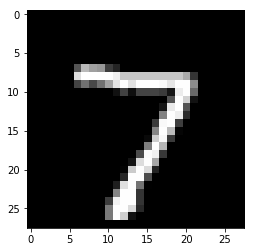

label: 7


In [9]:
# 테스트 이미지를 넣고 라벨을 받음
x, t = test[0]
plt.imshow(x.reshape(28, 28), cmap='gray')
plt.show()
print('label:', t)

In [10]:
from chainer.cuda import to_gpu

# mini-batch로 모양을 바꿔줌
# 이 예제에서는 mini-batch는 1임
# 어떠한 mini-batch size를 사용해도 작동함

print(x.shape, end=' -> ')
x = x[None, ...]
print(x.shape)

# 데이터 저장과 계산을 GPU에서 수행하게 함
x = to_gpu(x, 0)

# X를 인수로 전달하여 forward 계산 수행
y = infer_model(x)

# 결과가 Variable 형태로 주어지기 때문에 Variable의 속성인 data를 활용하여 값을 얻을 수 있음
y = y.data

# GPU 결과를 CPU에게 전달함
y = to_cpu(y)

# argmax 함수를 이용하여 가장 적절한 라벨을 고름
pred_label = y.argmax(axis=1)

print('predicted label:', pred_label[0])

(784,) -> (1, 784)
predicted label: 7
